In [193]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD

import numpy as np
import re
import string
import nltk

from wordcloud import WordCloud, STOPWORDS
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

In [45]:
train_df = pd.read_csv('data/book_review_labelled_data.csv')
print(train_df.shape)
train_df = train_df.drop('overall', axis=1)
train_df.head(10)

(49992, 9)


,reviewerID,reviewerName,reviewText,summary,reviewTime,rates_count,helpful_count,rating
0,A3UPFTGAWZ3G2R,David J. Loftus,"Jenkins, a history professor and Member of Par...","Quite readable, nicely done","12 6, 2001",40,37,4
1,A1XTKTLNSCRLDS,Ellen Rappaport,Detective Inspector Erlendur Sveinsson is at h...,Mesmerizing in depth,"02 23, 2014",0,0,5
2,A1A77B6DQQH436,"crescamp ""esc""",I didn't read this. I purchased it for a gift...,10-minute life lessons for kids,"02 12, 2013",3,0,3
3,AEAF4MRYHJZI,"Angelia Menchan ""acvermen.blogspot.com""",Fierce Angels by Sheri Park reads like a disse...,So FIERCE,"03 24, 2010",9,9,4
4,A3B7KU72LGWFER,"Grifel ""Tea Time""",Clearly this author had two goals in mind: 1) ...,Drivel!,"06 21, 2003",19,13,1
5,A3JD07VHDLT5FF,"isala ""Isabel and Lars""",This is a collection of stories and memories b...,Compelling stories by ordinary people,"03 19, 2005",7,5,5
6,A1JBVAMC9YU0WD,ED,I am so glad I borrowed this 'book' from the l...,this 'cheese' stinks,"09 25, 2000",6,5,1
7,A1O7OXC13G9X3E,"kayp75 ""kayp75""","Really enjoyable, couldn't put it down. The ch...",great read,"10 21, 2013",0,0,5
8,A1RAUVCWYHTQI4,A. Ross,I don't read a lot of science-fiction (maybe f...,Lots of Good Elements Fail to Add Up to an Eng...,"08 4, 2010",3,2,3
9,A3PZTH1DTX6O6B,"H. F. Gibbard ""History Buff""",Legendary pornographer Larry Flynt teamed up w...,fun but occasionally debatable history of pres...,"06 11, 2011",5,4,4


In [46]:
test_df = pd.read_csv('data/book_review_test_data_unlabelled.csv')
print(test_df.shape)
test_df.head(10)

(2000, 6)


,reviewerID,reviewerName,reviewText,summary,reviewTime,rating
0,A2HESNQJZ9OB7H,Jen,So boring and stupid had a hard time finishing...,Unbelievable.,"02 16, 2014",1
1,A1ABXPSFA9PC8N,Ben Parker,Ill be the first to admit i'm not the best coo...,Easy and Clear Cooking,"11 7, 2012",5
2,AYVW3O6W8S5S4,Johnny in Texas,Doesn't tell you how to do anything... just s...,not bad,"02 25, 2014",3
3,A17GOTFSUAWN17,Tyson,Whenever I met my last two girlfriends in pers...,"Short book, but good primer on how to text girls","03 15, 2014",4
4,A2VO8K861AV83R,"Avatheps ""Avatheps""",I read the reviews and decided to take a chanc...,Very disappointing. I could not finish it.,"12 30, 2013",2
5,A60C622DQ0QNU,Eric Lass,This book is packed with some great tips on de...,Very Useful and Some Great Tips,"10 8, 2012",4
6,A1ULRFNOXE2I08,Kathy,"Thought this was a great read, but a little sh...",Kathy,"03 17, 2013",4
7,A31MN9X90I4SB6,"Jacqueline R Walton ""Jacqueline R. Walton""",I am sorry but I was bored with this book. I c...,Couldn't Finish,"10 10, 2013",1
8,A3BLT4A2WSSK6M,Barry Melius,I don't read to stimulate my mind but to relax...,Good Hearted Romp,"12 1, 2012",4
9,A313BU9OG6ZVPD,"Patricia ""pstub""",I tried to get into this book but just couldn'...,Nope,"05 3, 2014",1


In [47]:
train_df['useful_criteria'] = train_df['helpful_count']/train_df['rates_count']
print(train_df.shape)
train_df = train_df.dropna()
print(train_df.shape)

(49992, 9)
(28423, 9)


In [48]:
train_df['label_aux'] = train_df['useful_criteria'].apply(lambda x: 'true' if x >= 1 else 'false')

In [6]:
train_df.head()

,reviewerID,reviewerName,reviewText,summary,reviewTime,rates_count,helpful_count,rating,useful_criteria,label_aux
0,A3UPFTGAWZ3G2R,David J. Loftus,"Jenkins, a history professor and Member of Par...","Quite readable, nicely done","12 6, 2001",40,37,4,0.925000,false
1,A1XTKTLNSCRLDS,Ellen Rappaport,Detective Inspector Erlendur Sveinsson is at h...,Mesmerizing in depth,"02 23, 2014",0,0,5,NaN,false
2,A1A77B6DQQH436,"crescamp ""esc""",I didn't read this. I purchased it for a gift...,10-minute life lessons for kids,"02 12, 2013",3,0,3,0.000000,false
3,AEAF4MRYHJZI,"Angelia Menchan ""acvermen.blogspot.com""",Fierce Angels by Sheri Park reads like a disse...,So FIERCE,"03 24, 2010",9,9,4,1.000000,true
4,A3B7KU72LGWFER,"Grifel ""Tea Time""",Clearly this author had two goals in mind: 1) ...,Drivel!,"06 21, 2003",19,13,1,0.684211,false


In [ ]:
cleanup_re = re.compile('[^a-z]+')

def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
#     sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

In [ ]:
train_df['reviewText_cleaned'] = train_df['reviewText'].apply(cleanup)

In [ ]:
stopwords = set(STOPWORDS)

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(train_df[train_df['label_aux']=='true']["reviewText"])

In [ ]:
show_wordcloud(train_df[train_df['label_aux']=='false']["reviewText"])

In [ ]:
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()

In [ ]:
train_df['reviewText_tokenized'] = train_df['reviewText'].apply(lambda x: ' '.join(tokenizer.tokenize(x)))

In [ ]:
show_wordcloud(train_df[train_df['label_aux']=='false']['reviewText_tokenized'].values)

In [ ]:
show_wordcloud(train_df[train_df['label_aux']=='true']['reviewText_tokenized'].values)

# Script to label reviews

In [ ]:
null_df = train_df[train_df['useful_criteria'].isna()]

In [ ]:
for i, row in null_df.iterrows():
    print(row['summary'])
    print('\n')
    print(row['reviewText'])
    true = input()
    print('---------')
    if true == 'y':
        row['useful_criteria'] = 1
    elif true == 'n':
        row['useful_criteria'] = 0
    elif true == 'break':
        break
    else:
        continue
    null_df.at[i,'useful_criteria'] = row['useful_criteria']

In [ ]:
null_df.head()

In [ ]:
sample = pd.read_csv('data/sample_submission.csv')
sample

In [ ]:
train_df.head()

# Extra features

In [41]:
train_df = pd.read_csv('data/book_review_labelled_data.csv')
print(train_df.shape)
train_df = train_df.drop('overall', axis=1)
train_df.head(10)

(49992, 9)


,reviewerID,reviewerName,reviewText,summary,reviewTime,rates_count,helpful_count,rating
0,A3UPFTGAWZ3G2R,David J. Loftus,"Jenkins, a history professor and Member of Par...","Quite readable, nicely done","12 6, 2001",40,37,4
1,A1XTKTLNSCRLDS,Ellen Rappaport,Detective Inspector Erlendur Sveinsson is at h...,Mesmerizing in depth,"02 23, 2014",0,0,5
2,A1A77B6DQQH436,"crescamp ""esc""",I didn't read this. I purchased it for a gift...,10-minute life lessons for kids,"02 12, 2013",3,0,3
3,AEAF4MRYHJZI,"Angelia Menchan ""acvermen.blogspot.com""",Fierce Angels by Sheri Park reads like a disse...,So FIERCE,"03 24, 2010",9,9,4
4,A3B7KU72LGWFER,"Grifel ""Tea Time""",Clearly this author had two goals in mind: 1) ...,Drivel!,"06 21, 2003",19,13,1
5,A3JD07VHDLT5FF,"isala ""Isabel and Lars""",This is a collection of stories and memories b...,Compelling stories by ordinary people,"03 19, 2005",7,5,5
6,A1JBVAMC9YU0WD,ED,I am so glad I borrowed this 'book' from the l...,this 'cheese' stinks,"09 25, 2000",6,5,1
7,A1O7OXC13G9X3E,"kayp75 ""kayp75""","Really enjoyable, couldn't put it down. The ch...",great read,"10 21, 2013",0,0,5
8,A1RAUVCWYHTQI4,A. Ross,I don't read a lot of science-fiction (maybe f...,Lots of Good Elements Fail to Add Up to an Eng...,"08 4, 2010",3,2,3
9,A3PZTH1DTX6O6B,"H. F. Gibbard ""History Buff""",Legendary pornographer Larry Flynt teamed up w...,fun but occasionally debatable history of pres...,"06 11, 2011",5,4,4


In [42]:
train_df['useful_criteria'] = train_df['helpful_count']/train_df['rates_count']
print(train_df.shape)
train_df = train_df.dropna()
print(train_df.shape)

(49992, 9)
(28423, 9)


In [62]:
train_df['label_aux'] = train_df['useful_criteria'].apply(lambda x: 'true' if x >= 0.8 else 'false')

In [49]:
stop_words = nltk.corpus.stopwords.words('english')

In [50]:
train_df['reviewText_lower'] = train_df['reviewText'].str.lower()

In [51]:
train_df['reviewText_lower_no_punctuation'] = train_df['reviewText_lower'].apply(lambda x: re.sub(r'[^\w\s]','', x))

In [52]:
train_df['nb_words'] = train_df['reviewText_lower_no_punctuation'].apply(lambda x: len(x.split()))

In [53]:
train_df['nb_stopwords'] = train_df['reviewText_lower_no_punctuation'].apply(lambda x: len([word for word in x.split() if word in stop_words]))

In [54]:
train_df['avg_word_length'] = train_df['reviewText_lower_no_punctuation'].apply(lambda x: np.mean([len(t) for t in x.split()]) if np.mean([len(t) for t in x.split()  if t not in stop_words]) > 0 else 0)

In [56]:
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()
train_df['reviewText_tokenized'] = train_df['reviewText'].apply(lambda x: ' '.join(tokenizer.tokenize(x)))

In [58]:
train_df['nb_punctuation'] = train_df['reviewText_tokenized'].apply(lambda x: len([punct for punct in x.split() if punct in string.punctuation]))

In [69]:
train_df['nb_punctuation_normalized'] = train_df['nb_punctuation']/train_df['nb_words']
train_df['nb_stopwords_normalized'] = train_df['nb_stopwords']/train_df['nb_words']

In [70]:
train_df.head()

,reviewerID,reviewerName,reviewText,summary,reviewTime,rates_count,helpful_count,rating,useful_criteria,label_aux,reviewText_lower,reviewText_lower_no_punctuation,nb_words,nb_stopwords,avg_word_length,reviewText_tokenized,nb_punctuation,nb_punctuation_normalized,nb_stopwords_normalized
0,A3UPFTGAWZ3G2R,David J. Loftus,"Jenkins, a history professor and Member of Par...","Quite readable, nicely done","12 6, 2001",40,37,4,0.925000,true,"jenkins, a history professor and member of par...",jenkins a history professor and member of parl...,256,93,5.656250,"Jenkins , a history professor and Member of Pa...",69,0.269531,0.363281
2,A1A77B6DQQH436,"crescamp ""esc""",I didn't read this. I purchased it for a gift...,10-minute life lessons for kids,"02 12, 2013",3,0,3,0.000000,false,i didn't read this. i purchased it for a gift...,i didnt read this i purchased it for a gift f...,25,14,3.600000,I didn ' t read this . I purchased it for a gi...,2,0.080000,0.560000
3,AEAF4MRYHJZI,"Angelia Menchan ""acvermen.blogspot.com""",Fierce Angels by Sheri Park reads like a disse...,So FIERCE,"03 24, 2010",9,9,4,1.000000,true,fierce angels by sheri park reads like a disse...,fierce angels by sheri park reads like a disse...,272,123,4.580882,Fierce Angels by Sheri Park reads like a disse...,37,0.136029,0.452206
4,A3B7KU72LGWFER,"Grifel ""Tea Time""",Clearly this author had two goals in mind: 1) ...,Drivel!,"06 21, 2003",19,13,1,0.684211,false,clearly this author had two goals in mind: 1) ...,clearly this author had two goals in mind 1 to...,103,47,4.466019,Clearly this author had two goals in mind : 1 ...,17,0.165049,0.456311
5,A3JD07VHDLT5FF,"isala ""Isabel and Lars""",This is a collection of stories and memories b...,Compelling stories by ordinary people,"03 19, 2005",7,5,5,0.714286,false,this is a collection of stories and memories b...,this is a collection of stories and memories b...,261,134,4.743295,This is a collection of stories and memories b...,33,0.126437,0.513410


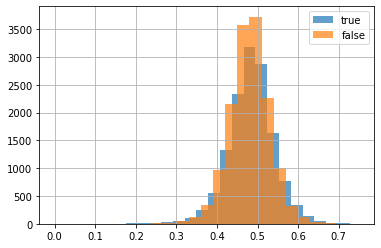

In [86]:
train_df.groupby('label_aux')['nb_stopwords_normalized'].hist(bins=25, alpha=0.7)
plt.plot()
plt.legend(train_df.label_aux)
plt.show()

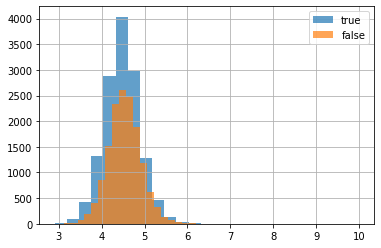

In [87]:
train_df.groupby('label_aux')['avg_word_length'].hist(bins=25, alpha=0.7)
plt.plot()
plt.legend(train_df.label_aux)
plt.show()

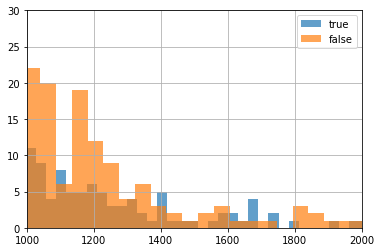

In [99]:
train_df.groupby('label_aux')['nb_words'].hist(bins=100, alpha=0.7)
plt.plot()
plt.legend(train_df.label_aux)
plt.xlim(1000, 2000)
plt.ylim(0, 30)
plt.show()

In [114]:
def corr_low(df,method='spearman'):
    corr = df.corr(method=method)
    mask_ = np.tril(np.ones(corr.shape)).astype(bool)
    corr_lower = corr.mask(mask_)
    plt.figure(figsize=(12,5))
    sns.heatmap(corr_lower,
               annot=True,
               cmap='RdBu_r')
    plt.show()

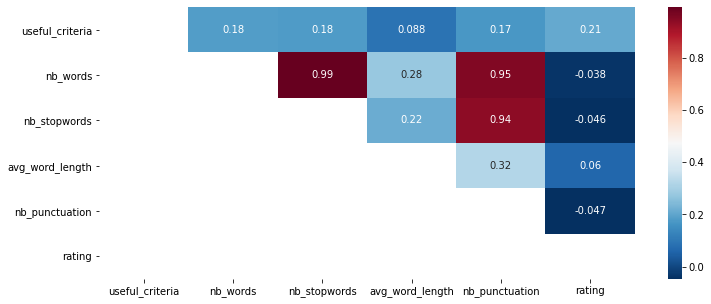

In [115]:
corr_low(train_df[['useful_criteria', 'nb_words', 'nb_stopwords', 'avg_word_length', 'nb_punctuation', 'rating']])

In [116]:
train_df['summary_lower'] = train_df['summary'].str.lower()

train_df['summary_lower_no_punctuation'] = train_df['summary_lower'].apply(lambda x: re.sub(r'[^\w\s]','', x))

train_df['nb_words_summary'] = train_df['summary_lower_no_punctuation'].apply(lambda x: len(x.split()))

train_df['nb_stopwords_summary'] = train_df['summary_lower_no_punctuation'].apply(lambda x: len([word for word in x.split() if word in stop_words]))

train_df['avg_word_length_summary'] = train_df['summary_lower_no_punctuation'].apply(lambda x: np.mean([len(t) for t in x.split()]) if np.mean([len(t) for t in x.split()  if t not in stop_words]) > 0 else 0)

train_df['summary_tokenized'] = train_df['summary'].apply(lambda x: ' '.join(tokenizer.tokenize(x)))

train_df['nb_punctuation_summary'] = train_df['summary_tokenized'].apply(lambda x: len([punct for punct in x.split() if punct in string.punctuation]))

train_df['nb_punctuation_normalized_summary'] = train_df['nb_punctuation_summary']/train_df['nb_words_summary']
train_df['nb_stopwords_normalized_summary'] = train_df['nb_stopwords_summary']/train_df['nb_words_summary']

/home/josemfsantos/.virtualenvs/starters_academy/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


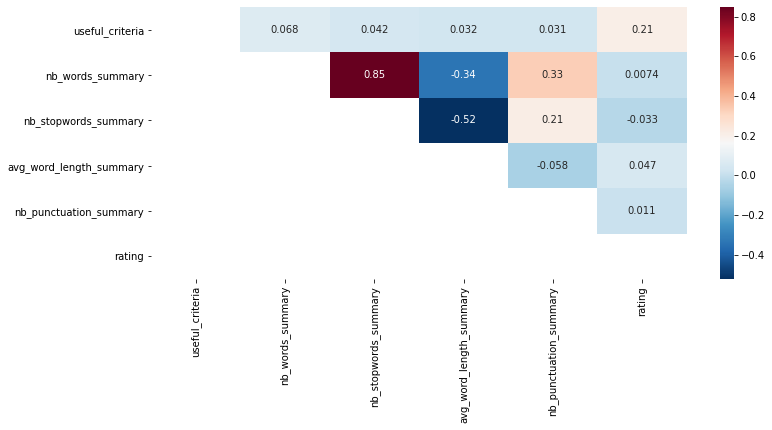

In [121]:
corr_low(train_df[['useful_criteria', 'nb_words_summary', 'nb_stopwords_summary', 'avg_word_length_summary', 'nb_punctuation_summary', 'rating']])

In [128]:
def create_extra_features(df):
    df['reviewText_lower'] = df['reviewText'].str.lower()
    df['reviewText_lower_no_punctuation'] = df['reviewText_lower'].apply(lambda x: re.sub(r'[^\w\s]','', x))

    df['nb_words'] = df['reviewText_lower_no_punctuation'].apply(lambda x: len(x.split()))
    df['nb_stopwords'] = df['reviewText_lower_no_punctuation'].apply(lambda x: len([word for word in x.split() if word in stop_words]))

    df['avg_word_length'] = df['reviewText_lower_no_punctuation'].apply(lambda x: np.mean([len(t) for t in x.split()]) if np.mean([len(t) for t in x.split()  if t not in stop_words]) > 0 else 0)

    tokenizer = WordPunctTokenizer()
    df['reviewText_tokenized'] = df['reviewText'].apply(lambda x: ' '.join(tokenizer.tokenize(x)))

    df['nb_punctuation'] = df['reviewText_tokenized'].apply(lambda x: len([punct for punct in x.split() if punct in string.punctuation]))

    df['nb_punctuation_normalized'] = df['nb_punctuation']/df['nb_words']
    df['nb_stopwords_normalized'] = df['nb_stopwords']/df['nb_words']
    
    df = df.drop(['reviewText_lower', 'reviewText_lower_no_punctuation', 'reviewText_tokenized'], axis=1)
    new_cols = ['nb_words', 'nb_stopwords', 'avg_word_length', 'nb_punctuation', 'nb_punctuation_normalized', 'nb_stopwords_normalized']
    return df, new_cols

In [168]:
train_df = pd.read_csv('data/book_review_labelled_data.csv')
train_df = train_df.drop('overall', axis=1)

train_df['useful_criteria'] = train_df['helpful_count']/train_df['rates_count']
train_df = train_df.dropna()

train_df['label_aux'] = train_df['useful_criteria'].apply(lambda x: 'true' if x >= 0.8 else 'false')

X_train, cols = create_extra_features(train_df)

In [167]:
X_train_ = X_train[cols]

KeyError: "None of [Index(['nb_words', 'nb_stopwords', 'avg_word_length', 'nb_punctuation',\n       'nb_punctuation_normalized', 'nb_stopwords_normalized'],\n      dtype='object')] are in the [index]"

In [163]:
y_train = X_train['label_aux']

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X_train_, y_train,  test_size=0.2, random_state=42)

In [166]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

AttributeError: 'Series' object has no attribute 'reshape'

In [154]:
y_pred = rf.predict(X_test)

In [156]:
accuracy_score(y_test, y_pred)

0.5326297273526825

In [183]:
count_vect = CountVectorizer(ngram_range = (1, 2))
X_train_counts = count_vect.fit_transform(X_train["reviewText"])

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [184]:
y_train = X_train["label_aux"]

In [185]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg_result = logreg.fit(X_train_tfidf, y_train)
# prediction['Logistic'] = logreg.predict(X_test_tfidf)

/home/josemfsantos/.virtualenvs/starters_academy/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [186]:
words = count_vect.get_feature_names()

feature_coefs = pd.DataFrame(
    data = list(zip(words, logreg_result.coef_[0])),
    columns = ['feature', 'coef'])

feature_coefs.sort_values(by='coef')

,feature,coef
211298,boring,-2.492268
957664,not,-1.962958
1539393,waste,-1.486574
951504,no,-1.474341
1253785,should,-1.466248
...,...,...
812813,life,1.860011
648929,highly,1.891146
424065,each,1.915512
1578584,with,2.237484


In [211]:
train_df.shape

(28423, 19)

In [212]:
y_train = train_df["label_aux"]
X_train, X_test, y_train, y_test = train_test_split(train_df, y_train,  test_size=0.2, random_state=42)

In [219]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train["reviewText"])
# X_test = vectorizer.transform(test_data.Tweet)

svd = TruncatedSVD(n_components=300, random_state=42)
svd.fit(X_train)
X_train_svd = svd.transform(X_train)
# X_test_svd =  svd.transform(X_test)

clf =  RandomForestClassifier()
clf.fit(X_train_svd, y_train)

IndexError: Index dimension must be <= 2

In [217]:
X_test = vectorizer.transform(X_test["reviewText"])
X_test_svd =  svd.transform(X_test)
y_pred = clf.predict(X_test_svd)

In [218]:
accuracy_score(y_test, y_pred)

0.5632365875109938